In [31]:
# tokenization 
#stemming 
#lemmatization


## Data Preparation

In [62]:
import pandas as pd 
import numpy as np 
import nltk
from nltk.stem.porter import PorterStemmer
stemmer=PorterStemmer()
nltk.download('punkt_tab')
import matplotlib.pyplot as plt
import time
import random

[nltk_data] Downloading package punkt_tab to /home/puzan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [61]:
def tokenize(sentence):
    return nltk.word_tokenize(sentence)
    
def stem(word):
    " Stemmize the word"
    return stemmer.stem(word.lower())
def bag_of_words(tokenized_sentence,all_words):
    """Return bags of words"""
    tokenized_sentence=[stem(w) for w in tokenized_sentence]
    bag=np.zeros(len(all_words),dtype=np.float32)
    for idx,w in enumerate (all_words):
        if w in tokenized_sentence:
            bag[idx]=1.0
    return bag


In [34]:
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset,DataLoader

In [35]:
# training 
import json



In [36]:
with open('data.json','r') as f :
    intents=json.load(f)

In [37]:
all_words=[]
tags=[]
xy=[]
for i in intents['intents']:
    tag=i['tag']
    tags.append(tag)
    for pattern in i['patterns']:
        w=nltk.word_tokenize(pattern) #tokeinize the words
        all_words.extend(w)
        xy.append((w,tag))
remove_words=['!','?','.',',']
all_words=[stem(w) for w in all_words if w not in remove_words] #stem and remove the pucntuation
all_words=sorted(set(all_words)) #get unique 
tags=sorted(set(tags))

In [38]:
X_train=[]
y_train=[]
for (pattern_words,tag) in xy:
    bag=bag_of_words(pattern_words,all_words) #implementing bow
    X_train.append(bag)
    label=tags.index(tag)
    y_train.append(label)# Cross entropy

X_train=np.array(X_train)
y_train=np.array(y_train)


## Dataset and Dataloading

In [39]:
class Mydataset(Dataset):
    def __init__(self) -> None:
        self.n_samples = len(X_train)
        self.x_data=X_train
        self.y_data=y_train
    
    def __len__(self) -> int:
        return self.n_samples
    
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]

In [40]:
dataset=Mydataset()
batch_size=8
train_loader=DataLoader(dataset=dataset,batch_size=8,shuffle=True,num_workers=2)

In [41]:
# making pytorch model

## Model for training

In [42]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_size,hidden_size,output_classes):
        super().__init__()
        self.l1=nn.Linear(input_size,hidden_size)
        self.l2=nn.Linear(hidden_size,hidden_size)
        self.l3=nn.Linear(hidden_size,output_classes)
        self.relu=nn.ReLU()
    
    def forward(self,x):
        out=self.l1(x)
        out=self.relu(out)
        out=self.l2(out)
        out=self.relu(out)
        out=self.l3(out)
        return out




In [56]:
num_epochs=200
input_size=len(X_train[0])
hidden_size=8
output_classes=len(tags)

In [57]:
model=NeuralNetwork(input_size=input_size,hidden_size=hidden_size,output_classes=output_classes)


In [44]:
device=torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

## Model training on different optimizers

In [46]:
#loss and optimizer 
start_time = time.time()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
model.to(device)
losses=[]
for epoch in range(num_epochs):
    for words,label in train_loader:
        words=words.to(device)
        label=label.to(device)
        #forward pass
        output=model(words)
        loss=criterion(output,label)
        #backward and optimizer 
        optimizer.zero_grad()
        #to calc gradients
        loss.backward()
        optimizer.step()# update weights 
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
end_time = time.time()
print(f"Final cost,loss={loss.item():.5f}")
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Epoch [10/200], Loss: 2.0397
Epoch [20/200], Loss: 2.0200
Epoch [30/200], Loss: 1.8482
Epoch [40/200], Loss: 1.9109
Epoch [50/200], Loss: 1.7537
Epoch [60/200], Loss: 1.7361
Epoch [70/200], Loss: 1.6655
Epoch [80/200], Loss: 1.5052
Epoch [90/200], Loss: 1.5786
Epoch [100/200], Loss: 1.2130
Epoch [110/200], Loss: 1.1712
Epoch [120/200], Loss: 0.6081
Epoch [130/200], Loss: 0.1963
Epoch [140/200], Loss: 1.1045
Epoch [150/200], Loss: 0.4201
Epoch [160/200], Loss: 0.5193
Epoch [170/200], Loss: 0.2436
Epoch [180/200], Loss: 0.8717
Epoch [190/200], Loss: 0.4470
Epoch [200/200], Loss: 0.1587
Final cost,loss=0.15868
Total training time: 26.92 seconds


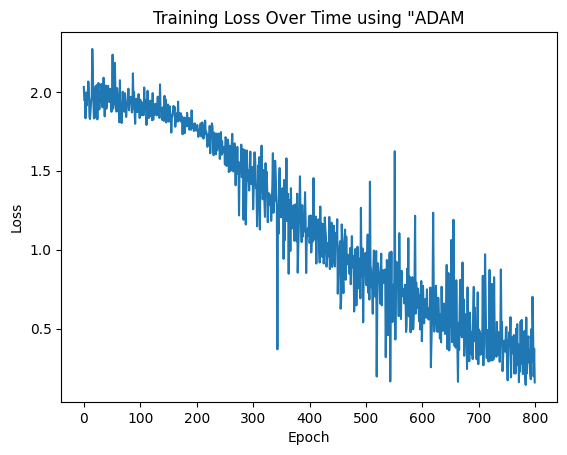

In [47]:

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time using "ADAM')
plt.show()

In [48]:
#using stochastic gradient descent

In [49]:
#loss and optimizer 
start_time = time.time()
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model.to(device)
losses=[]
for epoch in range(num_epochs):
    for words,label in train_loader:
        words=words.to(device)
        label=label.to(device)
        #forward pass
        output=model(words)
        loss=criterion(output,label)
        #backward and optimizer 
        optimizer.zero_grad()
        #to calc gradients
        loss.backward()
        optimizer.step()# update weights 
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
end_time = time.time()
print(f"Final cost,loss={loss.item():.5f}")
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Epoch [10/200], Loss: 0.1289
Epoch [20/200], Loss: 0.1356
Epoch [30/200], Loss: 0.2139
Epoch [40/200], Loss: 0.0180
Epoch [50/200], Loss: 0.0242
Epoch [60/200], Loss: 0.0298
Epoch [70/200], Loss: 0.0448
Epoch [80/200], Loss: 0.0209
Epoch [90/200], Loss: 0.0044
Epoch [100/200], Loss: 0.0043
Epoch [110/200], Loss: 0.0029
Epoch [120/200], Loss: 0.0154
Epoch [130/200], Loss: 0.0048
Epoch [140/200], Loss: 0.0062
Epoch [150/200], Loss: 0.0057
Epoch [160/200], Loss: 0.0202
Epoch [170/200], Loss: 0.0093
Epoch [180/200], Loss: 0.0026
Epoch [190/200], Loss: 0.0020
Epoch [200/200], Loss: 0.0053
Final cost,loss=0.00532
Total training time: 29.22 seconds


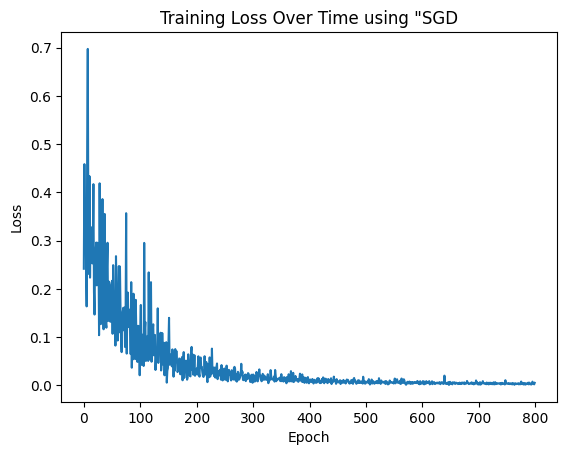

In [50]:

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time using "SGD')
plt.show()

In [51]:
# using RMSPROP
start_time = time.time()
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)

model.to(device)
losses=[]
for epoch in range(num_epochs):
    for words,label in train_loader:
        words=words.to(device)
        label=label.to(device)
        #forward pass
        output=model(words)
        loss=criterion(output,label)
        #backward and optimizer 
        optimizer.zero_grad()
        #to calc gradients
        loss.backward()
        optimizer.step()# update weights 
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
end_time = time.time()
print(f"Final cost,loss={loss.item():.5f}")
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Epoch [10/200], Loss: 0.0000
Epoch [20/200], Loss: 0.0002
Epoch [30/200], Loss: 0.0001
Epoch [40/200], Loss: 0.0000
Epoch [50/200], Loss: 0.0002
Epoch [60/200], Loss: 0.0000
Epoch [70/200], Loss: 0.0000
Epoch [80/200], Loss: 0.0000
Epoch [90/200], Loss: 0.0001
Epoch [100/200], Loss: 0.0000
Epoch [110/200], Loss: 0.0000
Epoch [120/200], Loss: 0.0001
Epoch [130/200], Loss: 0.0000
Epoch [140/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [160/200], Loss: 0.0000
Epoch [170/200], Loss: 0.0000
Epoch [180/200], Loss: 0.0000
Epoch [190/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000
Final cost,loss=0.00000
Total training time: 31.45 seconds


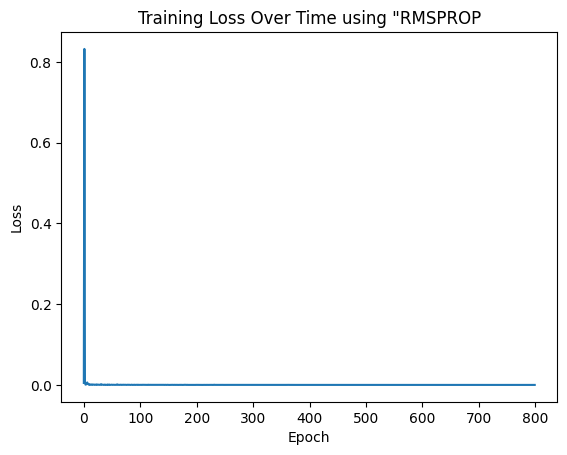

In [52]:

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time using "RMSPROP')
plt.show()

In [53]:
# ?using RMSPROP
start_time = time.time()
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)


model.to(device)
losses=[]
for epoch in range(num_epochs):
    for words,label in train_loader:
        words=words.to(device)
        label=label.to(device)
        #forward pass
        output=model(words)
        loss=criterion(output,label)
        #backward and optimizer 
        optimizer.zero_grad()
        #to calc gradients
        loss.backward()
        optimizer.step()# update weights 
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
end_time = time.time()
print(f"Final cost,loss={loss.item():.5f}")
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Epoch [10/200], Loss: 0.0000
Epoch [20/200], Loss: 0.0000
Epoch [30/200], Loss: 0.0000
Epoch [40/200], Loss: 0.0000
Epoch [50/200], Loss: 0.0000
Epoch [60/200], Loss: 0.0000
Epoch [70/200], Loss: 0.0000
Epoch [80/200], Loss: 0.0000
Epoch [90/200], Loss: 0.0000
Epoch [100/200], Loss: 0.0000
Epoch [110/200], Loss: 0.0000
Epoch [120/200], Loss: 0.0000
Epoch [130/200], Loss: 0.0000
Epoch [140/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [160/200], Loss: 0.0000
Epoch [170/200], Loss: 0.0000
Epoch [180/200], Loss: 0.0000
Epoch [190/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000
Final cost,loss=0.00000
Total training time: 23.04 seconds


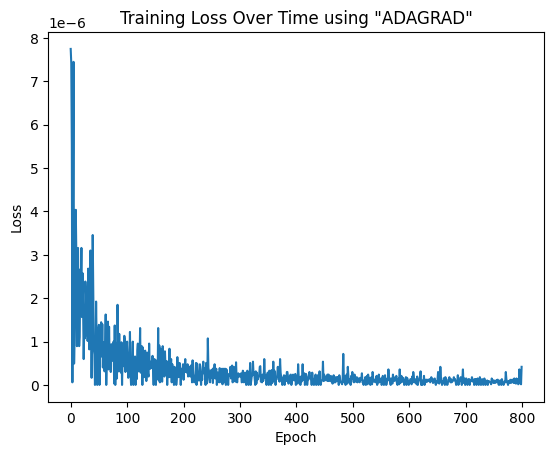

In [54]:

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time using "ADAGRAD"')
plt.show()

## Model Evaluation

In [59]:
data={
    "model_state":model.state_dict(),
    "input_size":input_size,
    "hidden_size":hidden_size,
    "all_words":all_words,
    "tags":tags
}
FILE_PATH="data.pth"
torch.save(data,FILE_PATH)

In [68]:
with open('data.json', 'r') as f:
    intents=json.load(f)
data=torch.load(FILE_PATH)
model=NeuralNetwork(input_size,hidden_size,output_classes)
model_state=data['model_state']
model.load_state_dict(model_state)
model.eval()


/tmp/ipykernel_134083/4220059822.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data=torch.load(FILE_PATH)


NeuralNetwork(
  (l1): Linear(in_features=54, out_features=8, bias=True)
  (l2): Linear(in_features=8, out_features=8, bias=True)
  (l3): Linear(in_features=8, out_features=7, bias=True)
  (relu): ReLU()
)

In [70]:
name="Helper"
print(" Want help : type 'q' to exit ")
while True:
    sentence=input("User:")
    if sentence=="q":
        break
    sentence=tokenize(sentence)
    X=bag_of_words(sentence,all_words)
    x=X.reshape(1,X.shape[0])
    x=torch.from_numpy(x)
    output=model(x)
    _,predicted=torch.max(output,dim=1)
    tag=tags[predicted.item()]
    probs=torch.softmax(output,dim=1)
    prob=probs[0][predicted.item()]
    print(prob)
    if prob.item()>0.75:
        for intent in intents['intents']:
            if tag == intent['tag']:
                print(f"{name}:{random.choice[intent['responses']]}")
    else:
        print(f"{name}: I didnot understand")






 Want help : type 'q' to exit 
tensor(0.1960, grad_fn=<SelectBackward0>)
Helper: I didnot understand
tensor(0.1924, grad_fn=<SelectBackward0>)
Helper: I didnot understand
tensor(0.1964, grad_fn=<SelectBackward0>)
Helper: I didnot understand
